## Details

#### Name: Akshat Toolaj Sinha
#### Entry Number: 2020CSB1068
#### Equity: Tech Mahindra

## Libraries & Constants

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
import yfinance as yf
import datetime
import os
import matplotlib.dates as mdates
from arch import arch_model
from scipy.stats import norm

In [2]:
# Defining Image Parameters
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_palette('flare')
sns.set_style("darkgrid")
sns.despine()


<Figure size 1200x800 with 0 Axes>

In [3]:
# Defining Constants for the Project

TICKER='TECHM.NS'
PERIOD='max'
FILE_NAME='TECH_MAHINDRA.csv'
PRICE_ANALYSIS='Close'
EQUITY_NAME='Tech Mahindra'
SIGNIFICANCE_LEVEL=0.05
TRADING_DAYS=252
YEAR_DAYS=365
OPTION_EXPIRY=datetime.date(2024,5,31)
TODAY=datetime.date.today()

# Risk Free Rate for 91 Days
RISK_FREE_RATE= 6.87

## Data Downloading & Augmentation

In [4]:
# Downloading Data
Equity_df=yf.download(TICKER,period=PERIOD,auto_adjust=True)

[*********************100%%**********************]  1 of 1 completed


In [5]:
# Data Cleaning
Equity_df.reset_index(inplace=True)
Equity_df = Equity_df.round(4)

In [6]:
# Dumping Data
Equity_df.to_csv(FILE_NAME,index=False)

## Data Visualization

Plotting Equity price 

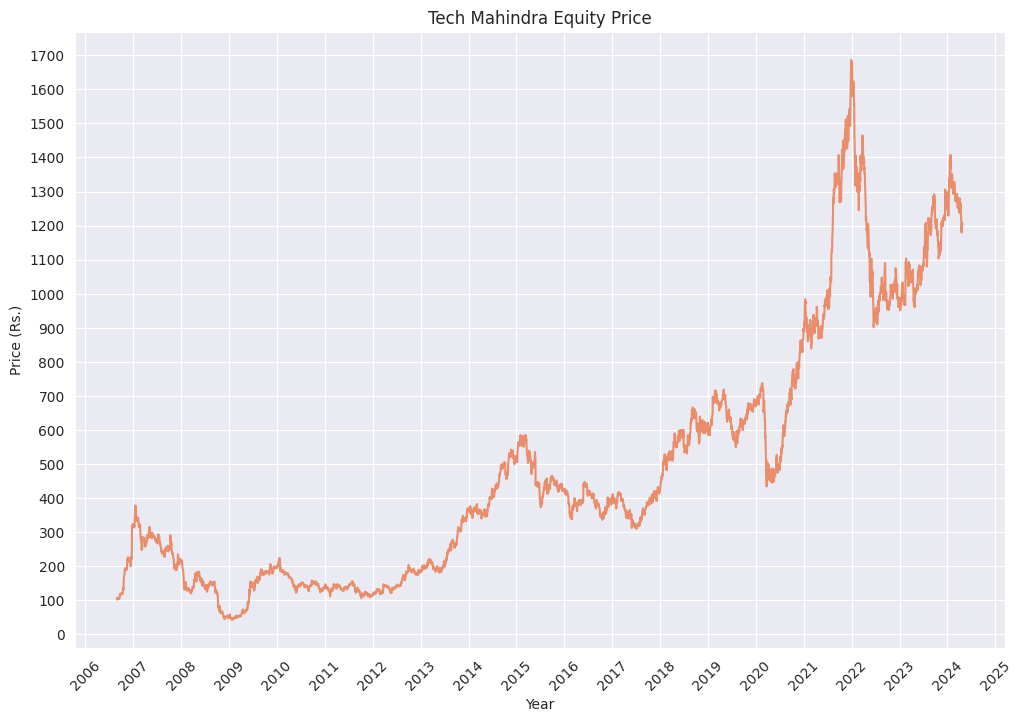

In [7]:
# Plotting Price chart
sns.lineplot(data=Equity_df,x='Date',y=PRICE_ANALYSIS)
plt.xlabel("Year")
plt.ylabel("Price (Rs.)")
plt.title(EQUITY_NAME+ " Equity Price")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.yticks(range(0,int(max(Equity_df[PRICE_ANALYSIS]))+100,100))
plt.show()

Plotting Log Returns

In [8]:
log_returns=np.log(Equity_df[PRICE_ANALYSIS]/Equity_df[PRICE_ANALYSIS].shift(1))

In [9]:
log_returns=log_returns.dropna()
log_returns.reset_index(drop=True,inplace=True)

In [10]:
log_returns=log_returns*100

In [11]:
dates=Equity_df['Date'][1:]

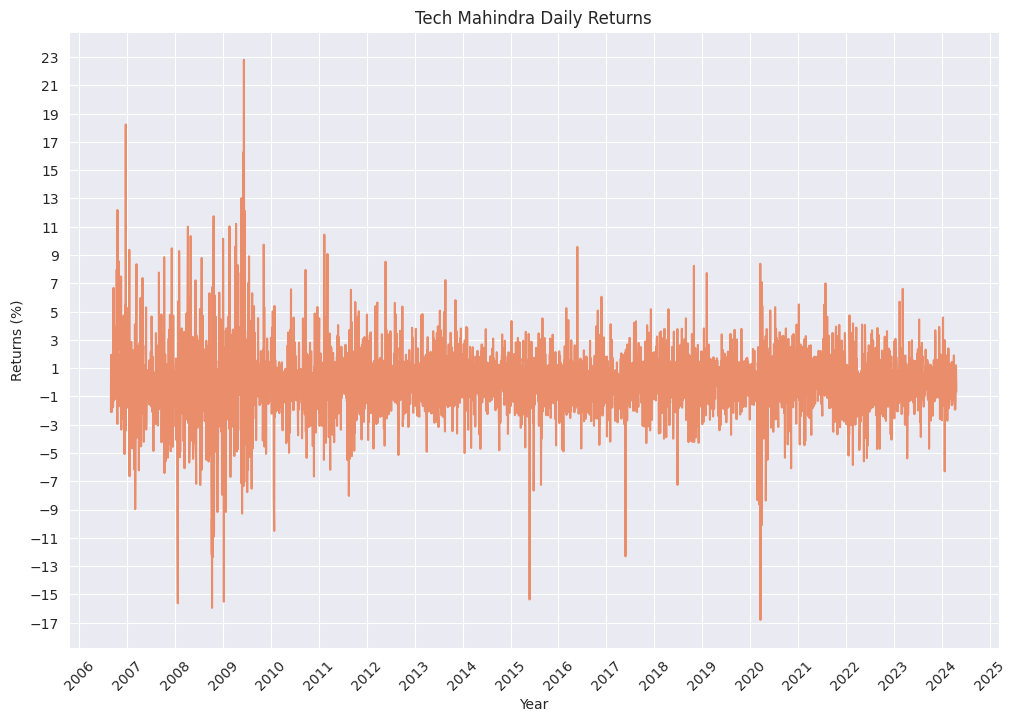

In [12]:
# Plotting Log Returns
sns.lineplot(x=dates,y=log_returns)
plt.xlabel("Year")
plt.ylabel("Returns (%)")
plt.title(EQUITY_NAME+" Daily Returns")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)
plt.yticks(np.arange(int(min(log_returns))-1,max(log_returns)+1,2))
plt.show()

## Normality Tests

Performing various normality test on log returns

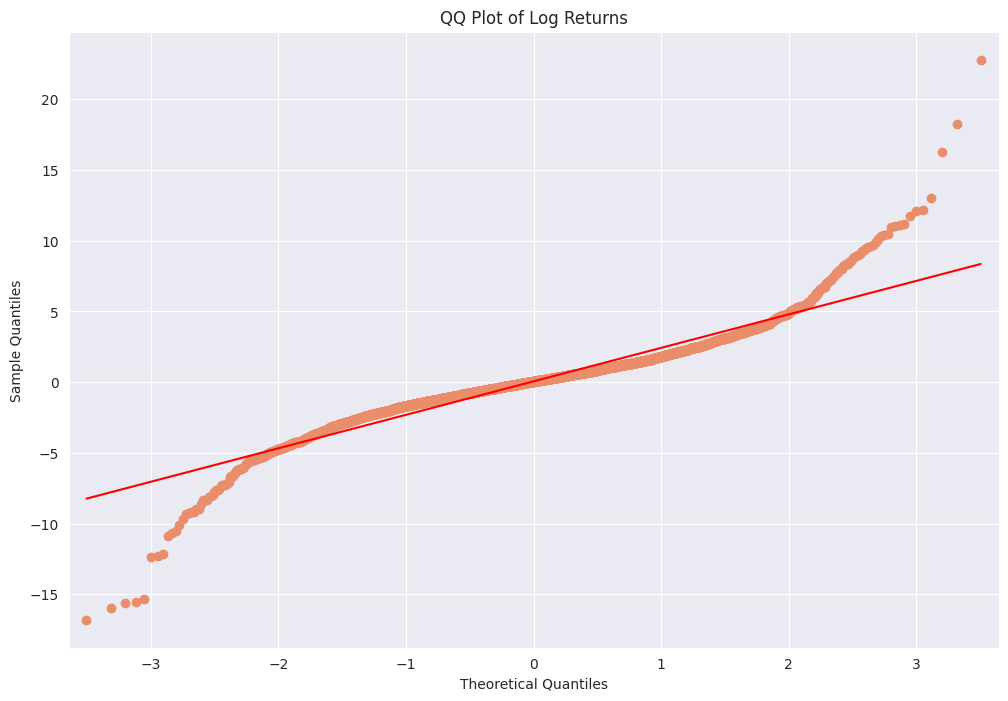

In [13]:
from statsmodels.graphics.gofplots import qqplot

qqplot(log_returns,line='s')
plt.title("QQ Plot of Log Returns")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

<AxesSubplot:xlabel='Close', ylabel='Count'>

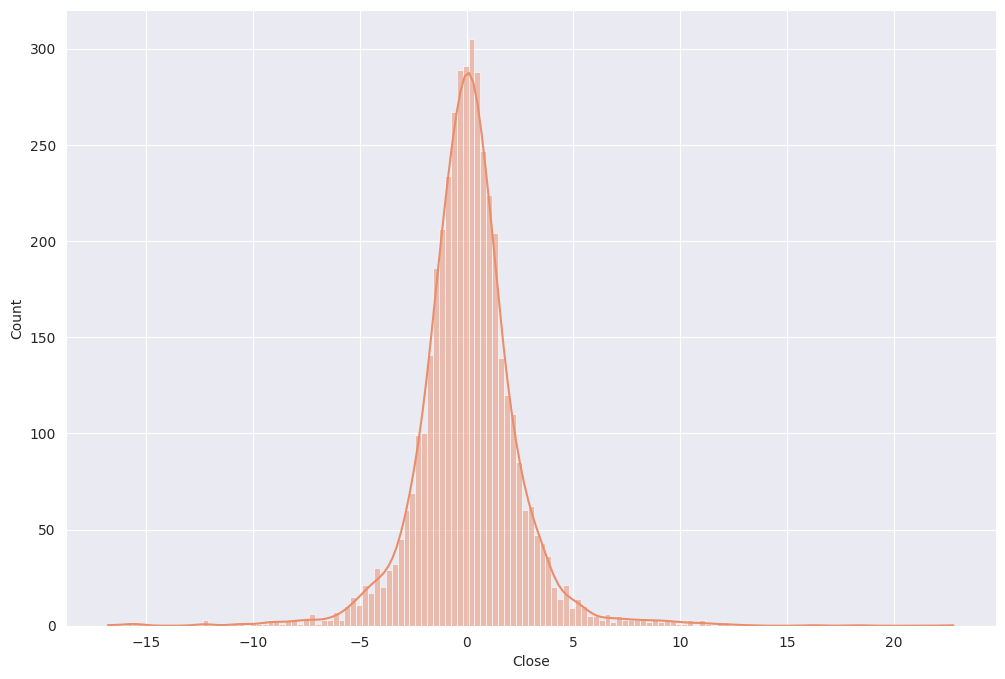

In [14]:
# KDE Plot
sns.histplot(log_returns,kde=True)

In [15]:
# Moment of log-returns distribution
print("Mean of Log Returns: ",round(log_returns.mean(),4))
print("Standard Deviation of Log Returns: ",round(log_returns.std(),4))
print("Skewness of Log Returns: ",round(log_returns.skew(),4))
print("Kurtosis of Log Returns: ",round(log_returns.kurtosis(),4))

Mean of Log Returns:  0.0559
Standard Deviation of Log Returns:  2.3689
Skewness of Log Returns:  0.2003
Kurtosis of Log Returns:  8.6199


Since Kurtosis & Standard Deviation is very high, we have fat tails resulting in leptokurtic distribution which tells that large change are frequent

In [16]:
# Jarque-Bera Test
from scipy.stats import jarque_bera


jb_test=jarque_bera(log_returns)
print("Jarque-Bera Test Statistic: ",jb_test[0])
print("Jarque-Bera Test P-Value: ",jb_test[1])

if jb_test[1]<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")

Jarque-Bera Test Statistic:  13464.210877820511
Jarque-Bera Test P-Value:  0.0

Reject Null Hypothesis: The data is not normally distributed


In [17]:
# Kolmogorov-Smirnov Test
from scipy.stats import kstest

ks_test=kstest(log_returns,'norm')

print("\nKolmogorov-Smirnov Test Statistic: ",ks_test.statistic)
print("Kolmogorov-Smirnov Test P-Value: ",ks_test.pvalue)

if ks_test.pvalue<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")


Kolmogorov-Smirnov Test Statistic:  0.1309670664803827
Kolmogorov-Smirnov Test P-Value:  1.5635432971975476e-65

Reject Null Hypothesis: The data is not normally distributed


In [18]:
# Shapiro-Wilk Test
from scipy.stats import shapiro

shapiro_test=shapiro(log_returns)

print("\nShapiro-Wilk Test Statistic: ",shapiro_test[0])
print("Shapiro-Wilk Test P-Value: ",shapiro_test[1])

if shapiro_test[1]<SIGNIFICANCE_LEVEL:
    print("\nReject Null Hypothesis: The data is not normally distributed")
else:
    print("\nFail to Reject Null Hypothesis : The data is normally distributed")


Shapiro-Wilk Test Statistic:  0.9122052192687988
Shapiro-Wilk Test P-Value:  1.1210387714598537e-44

Reject Null Hypothesis: The data is not normally distributed


## Returns Analysis

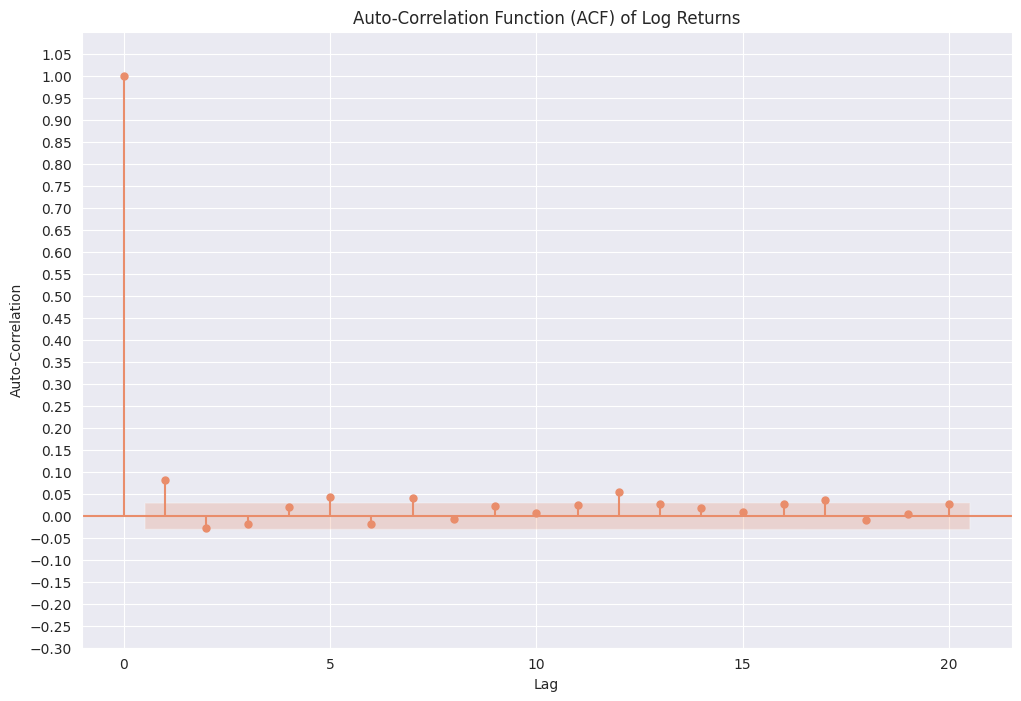

In [19]:
# Autocorrelation test in log Returns

import statsmodels.api as sm

sm.graphics.tsa.plot_acf(log_returns,lags=20)
plt.xlabel('Lag')
plt.ylabel("Auto-Correlation")
plt.title("Auto-Correlation Function (ACF) of Log Returns")
plt.ylim(-0.3,1.1)
plt.yticks(np.arange(-0.3,1.1,0.05))
plt.show()



There is autocorrelation which can be infered from the above graph as even at large timestamp, correlation is breaching the limit

## Volatility Modelling

In [20]:
# Getting standard deviations from log returns to be used a historical volatility
HistoricalVolatility=np.std(log_returns)
AnnualHistoricalVolatility=HistoricalVolatility*math.sqrt(TRADING_DAYS)
print("\nHistorical Daily Volatility (%): ",HistoricalVolatility)
print("Historical Annual Volatility (%): ",AnnualHistoricalVolatility)


Historical Daily Volatility (%):  2.3686538522449143
Historical Annual Volatility (%):  37.601214210211054


In [21]:
# GARCH Modelling and selecting best models from given candidate models

CandidateModels=[(1,1),(1,2),(2,1),(2,2),(3,2),(2,3),(3,3)]

BestModel=None
BestModelStatistic= float('-inf')
Parameters=None

for p,q in CandidateModels:
    model=arch_model(log_returns,vol='Garch',p=p,q=q)
    model_fit=model.fit(disp='off')
    if model_fit.aic>BestModelStatistic:
        BestModelStatistic=model_fit.aic
        BestModel=model_fit
        Parameters=(p,q)

print("\nBest Parameters(p,q): ",Parameters)

GARCHVolatility=BestModel.forecast(horizon=1).variance.iloc[-1].values[-1]
AnnualGARCHVolatility=GARCHVolatility*math.sqrt(TRADING_DAYS)

print("\nGARCH Daily Volatility (%): ",GARCHVolatility)
print("GARCH Annual Volatility (%): ",AnnualGARCHVolatility)


Best Parameters(p,q):  (2, 1)

GARCH Daily Volatility (%):  2.756880688737799
GARCH Annual Volatility (%):  43.7641241800601


Since there is significant auto-correlation, GARCH modelling to predict volatility is prefered to historical volatility

## Option Pricing

In [22]:
def nCr(n,r):
    f = math.factorial
    return f(n)/(f(r)*f(n-r))

In [23]:
from abc import ABC,abstractmethod

# Defining Abstract Class for Option Pricing
class OptionPricing(ABC):

    # Volatility & Risk Free rate has to annualized in nature while maturity is data object
    @abstractmethod
    def __init__(self,spot_price,strike_price,risk_free_rate,volatility,maturity):
        pass

    @abstractmethod
    def OptionPrice(self,type):
        pass

    @abstractmethod
    def setStrikePrice(self,strikePrice):
        pass


In [24]:
class OptionPricingCRR(OptionPricing):

    # Cox-Ross-Rubinstein Model for Option Pricing
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,steps,dividentYield=0):
        # Standard Parameters
        self.s0=s0
        self.strikePrice=strikePrice
        self.steps=steps
        self.dividentYield=dividentYield

        self.YearMaturity=(maturity-TODAY).days/YEAR_DAYS

        self.volatility=Annualvolatility
        self.riskFreeRate=riskFreeRate

        self.delta=self.YearMaturity/self.steps
        self.u=math.exp(self.volatility*math.sqrt(self.delta))
        self.d=1/self.u
        
        self.riskNeutralProbability=(math.exp((self.riskFreeRate-self.dividentYield)*self.delta)-self.d)/(self.u-self.d)

    def OptionPrice(self,type='C'):

        FuturePrice=0

        for i in range(0,self.steps+1):
            equityPriceMaturity=self.s0*(self.u**i)*(self.d**(self.steps-i)) # Equity Price at Maturity

            if type=='C':
                profit=max(equityPriceMaturity-self.strikePrice,0) # Profit for Call Option
            else:
                profit=max(self.strikePrice-equityPriceMaturity,0) # Profit for Put Option

            prob=(self.riskNeutralProbability**i)*((1-self.riskNeutralProbability)**(self.steps-i)) # Probability of i up moves
            

            FuturePrice+=profit*nCr(self.steps,i)*prob # Expected Profit

        discountFactor=math.exp(-self.riskFreeRate*self.delta) # Discount Factor

        return FuturePrice*discountFactor # Option Price
    

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

In [25]:
class OptionPricingSimulation(OptionPricing):
    # Monte Carlo Simulation for Option Pricing
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,steps,dividentYield=0,numSimulations=100000):
        # Standard Parameters
        self.s0=s0
        self.strikePrice=strikePrice
        self.steps=steps
        self.dividentYield=dividentYield
        self.YearsMaturity=(maturity-TODAY).days/YEAR_DAYS

        self.dStep=self.YearsMaturity/self.steps

        self.volatility=Annualvolatility
        self.riskFreeRate=riskFreeRate
        
        self.numSimulations=numSimulations

    def OptionPrice(self,type='C'):

        totalPayoff=0 # Total Payoff

        for _ in range(self.numSimulations):

            trendTerm=(self.riskFreeRate-self.dividentYield-0.5*(self.volatility**2))*self.YearsMaturity # Trend Term
            volatilityTerm=self.volatility*math.sqrt(self.YearsMaturity)*np.random.normal() # Volatility Term

            equityPrice=self.s0*math.exp(trendTerm+volatilityTerm) # Equity Price at Maturity

            if type=='C':
                payoff=max(equityPrice-self.strikePrice,0) # Payoff for Call Option
            else:
                payoff=max(self.strikePrice-equityPrice,0) # Payoff for Put Option

            totalPayoff+=payoff
        
        AveragePayoff=totalPayoff/self.numSimulations # Average Payoff

        discountFactor=math.exp(-self.riskFreeRate*self.YearsMaturity) # Discount Factor
        
        return AveragePayoff*discountFactor # Option Price

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice
    

In [26]:
class OptionPricingBS(OptionPricing):
    # Black-Scholes Model for Option Pricing
    def __init__(self,s0,Annualvolatility,strikePrice,maturity,riskFreeRate,dividentYield=0):
        self.s0=s0
        self.strikePrice=strikePrice
        self.Annualvolatility=Annualvolatility
        self.dividentYield=dividentYield
        self.YearMaturity=(maturity-TODAY).days/YEAR_DAYS
        self.riskFreeRate=riskFreeRate

    def OptionPrice(self,type='C'):
        # Standard parameters
        term1=math.log(self.s0/self.strikePrice) 
        term2=(self.riskFreeRate-self.dividentYield+0.5*self.Annualvolatility**2)*self.YearMaturity 
        denominator=self.Annualvolatility*math.sqrt(self.YearMaturity)

        d1=(term1+term2)/denominator 
        d2=d1-self.Annualvolatility*math.sqrt(self.YearMaturity)

        if type=='C': # Call Option
            part1=self.s0*math.exp(-self.dividentYield*self.YearMaturity)*norm.cdf(d1) 
            part2=self.strikePrice*math.exp(-self.riskFreeRate*self.YearMaturity)*norm.cdf(d2)
            return part1-part2
        else: # Put Option
            part1=self.strikePrice*math.exp(-self.riskFreeRate*self.YearMaturity)*norm.cdf(-d2)
            part2=self.s0*math.exp(-self.dividentYield*self.YearMaturity)*norm.cdf(-d1)
            return part1-part2
        

    def setStrikePrice(self,strikePrice):
        self.strikePrice=strikePrice

In [27]:
# Defining arguments for Option Pricing
CurrentPrice=Equity_df[PRICE_ANALYSIS].iloc[-1]
strikePrice=int(CurrentPrice)-50 # ITM Strike Price for call option
RiskFreeRate=RISK_FREE_RATE/100
step=100
Volatility=AnnualHistoricalVolatility/100

In [28]:
# Making objects for Option Pricing

optionCRR_Historical=OptionPricingCRR(CurrentPrice,Volatility,strikePrice
                        ,OPTION_EXPIRY,RiskFreeRate,step)

optionSimulation_Historical=OptionPricingSimulation(CurrentPrice,Volatility,strikePrice,OPTION_EXPIRY,
                        RiskFreeRate,step)

optionBS_Historical=OptionPricingBS(CurrentPrice,Volatility,strikePrice,
                        OPTION_EXPIRY,RiskFreeRate)

Volatility=AnnualGARCHVolatility/100

optionCRR_GARCH=OptionPricingCRR(CurrentPrice,Volatility,strikePrice,OPTION_EXPIRY,
                        RiskFreeRate,step)

optionSimulation_GARCH=OptionPricingSimulation(CurrentPrice,Volatility,strikePrice,
                        OPTION_EXPIRY,RiskFreeRate,step)

optionBS_GARCH=OptionPricingBS(CurrentPrice,Volatility,strikePrice,
                        OPTION_EXPIRY,RiskFreeRate)

In [29]:
print("Strike Price: ",strikePrice)
print("\nEstimation using Historical Volatility\n")
print("Call-Option Price using Binomial Model: ",optionCRR_Historical.OptionPrice('C'))
print("Call-Option Price using Simulation Model: ",optionSimulation_Historical.OptionPrice('C'))
print("Call-Option Price using Black-Scholes Model: ",optionBS_Historical.OptionPrice('C'))

Strike Price:  1150

Estimation using Historical Volatility

Call-Option Price using Binomial Model:  91.28984461499749
Call-Option Price using Simulation Model:  90.49441991283088
Call-Option Price using Black-Scholes Model:  90.58888356603381


In [30]:
print("Strike Price: ",strikePrice)
print("\nEstimation using GARCH Volatility\n")
print("Call-Option Price using Binomial Model: ",optionCRR_GARCH.OptionPrice('C'))
print("Call-Option Price using Simulation Model: ",optionSimulation_GARCH.OptionPrice('C'))
print("Call-Option Price using Black-Scholes Model: ",optionBS_GARCH.OptionPrice('C'))

Strike Price:  1150

Estimation using GARCH Volatility

Call-Option Price using Binomial Model:  100.06280170597388
Call-Option Price using Simulation Model:  99.6736431467469
Call-Option Price using Black-Scholes Model:  99.20591875167929


In [31]:
strikePrice=int(CurrentPrice)+50 # New Strike Price for ITM Put Option

In [32]:
optionCRR_Historical.setStrikePrice(strikePrice)
optionSimulation_Historical.setStrikePrice(strikePrice)
optionBS_Historical.setStrikePrice(strikePrice)

print("Strike Price: ",strikePrice)
print("\nEstimation using Historical Volatility\n")
print("Put-Option Price using Binomial Model: ",optionCRR_Historical.OptionPrice('P'))
print("Put-Option Price using Simulation Model: ",optionSimulation_Historical.OptionPrice('P'))
print("Put-Option Price using Black-Scholes Model: ",optionBS_Historical.OptionPrice('P'))

Strike Price:  1250

Estimation using Historical Volatility

Put-Option Price using Binomial Model:  82.37794385319067
Put-Option Price using Simulation Model:  81.4434885223829
Put-Option Price using Black-Scholes Model:  81.69519348400274


In [33]:
optionCRR_GARCH.setStrikePrice(strikePrice)
optionSimulation_GARCH.setStrikePrice(strikePrice)
optionBS_GARCH.setStrikePrice(strikePrice)

print("Strike Price: ",strikePrice)
print("\nEstimation using GARCH Volatility\n")
print("Put-Option Price using Binomial Model: ",optionCRR_GARCH.OptionPrice('P'))
print("Put-Option Price using Simulation Model: ",optionSimulation_GARCH.OptionPrice('P'))
print("Put-Option Price using Black-Scholes Model: ",optionBS_GARCH.OptionPrice('P'))

Strike Price:  1250

Estimation using GARCH Volatility

Put-Option Price using Binomial Model:  91.84838628383467
Put-Option Price using Simulation Model:  91.18944440493462
Put-Option Price using Black-Scholes Model:  91.04605862358767
